In [35]:
#1.Imports
import pandas as pd
from sklearn.preprocessing import StandardScaler


In [ ]:
# 2. Chargement du dataset
df = pd.read_csv("movies.csv")
print(df.shape)
df.head()

In [ ]:
# 3. Sélection des variables utiles (avant sortie du film)
cols = [
    "budget",
    "runtime",
    "genres",
    "popularity",
    "vote_average",
    "vote_count",
    "original_language",
    "revenue"
]
df = df[cols]
df.head()


In [ ]:

# 4. Nettoyage des données
df.dropna(inplace=True)
df = df[df["budget"] > 0]
df = df[df["runtime"] > 0]
df.shape

In [ ]:
# 5. Création de la variable cible (Classe a prédire)
df["success"] = (df["revenue"] > df["budget"]).astype(int)
df["success"].value_counts()

In [ ]:
#6.Suppression du data leakage (revenu)
df.drop(columns=["revenue"], inplace=True)
df.head()


In [ ]:
#7.Séparation X / y
X = df.drop(columns=["success"])
y = df["success"]

print(X.shape)
print(y.shape)


In [ ]:
#8.Encodage des variables catégorielles (transformer les variables nominales en plusieurs variables binaires)
X = pd.get_dummies(
    X,
    columns=["genres", "original_language"],
    drop_first=True
)

X.head()


In [ ]:
#9.Normalisation
num_cols = ["budget", "runtime", "popularity", "vote_average", "vote_count"]

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

X[num_cols].describe()



In [46]:
#10. Export & vérifications finales
print(X.shape)
print(y.shape)

X.columns.to_series().to_csv("features_after_encoding.csv", index=False)
df.to_csv("dataset_final.csv", index=False)


(3762, 1058)
(3762,)


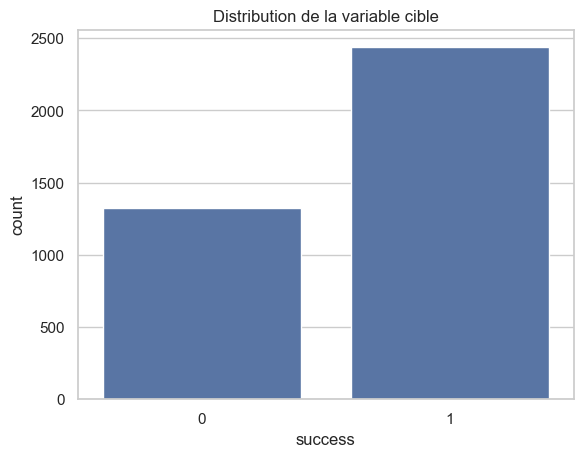

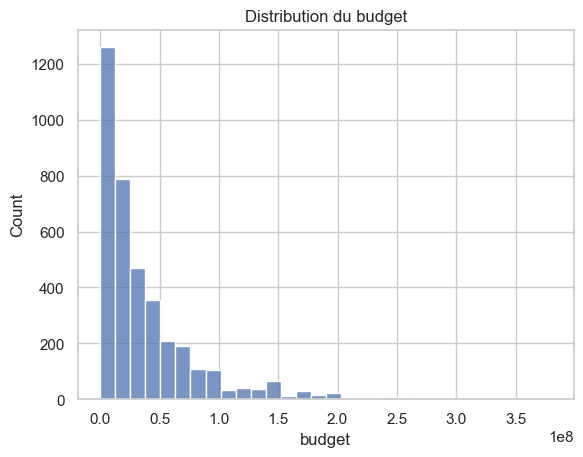

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x="success", data=df)
plt.title("Distribution de la variable cible")
plt.show()

sns.histplot(df["budget"], bins=30)
plt.title("Distribution du budget")
plt.show()


In [51]:
#Seperation Train/Test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)


(3009, 1058) (753, 1058)


In [52]:
#Métriques d’évaluation

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }


In [54]:
#Modèle 1 — Arbre de Décision

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

dt_results = evaluate_model(dt, X_test, y_test)
dt_results

{'Accuracy': 0.7423638778220452,
 'Precision': 0.787109375,
 'Recall': 0.8258196721311475,
 'F1-score': 0.806,
 'Confusion Matrix': array([[156, 109],
        [ 85, 403]])}

In [62]:
#Modèle 2 — K Plus Proches Voisins (KNN)

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

knn_results = evaluate_model(knn, X_test, y_test)
knn_results


{'Accuracy': 0.7463479415670651,
 'Precision': 0.7817836812144212,
 'Recall': 0.8442622950819673,
 'F1-score': 0.8118226600985222,
 'Confusion Matrix': array([[150, 115],
        [ 76, 412]])}

In [63]:
#Modèle 3 — Naïf Bayésien

from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

nb_results = evaluate_model(nb, X_test, y_test)
nb_results

{'Accuracy': 0.4169986719787517,
 'Precision': 0.7425742574257426,
 'Recall': 0.15368852459016394,
 'F1-score': 0.2546689303904924,
 'Confusion Matrix': array([[239,  26],
        [413,  75]])}

In [65]:
#Modèle 4 — Bagging

from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    random_state=42
)
bag.fit(X_train, y_train)

bag_results = evaluate_model(bag, X_test, y_test)
bag_results


{'Accuracy': 0.7888446215139442,
 'Precision': 0.8206627680311891,
 'Recall': 0.8627049180327869,
 'F1-score': 0.8411588411588412,
 'Confusion Matrix': array([[173,  92],
        [ 67, 421]])}

In [66]:
#Modèle 5 — Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)
rf.fit(X_train, y_train)

rf_results = evaluate_model(rf, X_test, y_test)
rf_results


{'Accuracy': 0.8047808764940239,
 'Precision': 0.8297872340425532,
 'Recall': 0.8790983606557377,
 'F1-score': 0.8537313432835821,
 'Confusion Matrix': array([[177,  88],
        [ 59, 429]])}

In [68]:
#Comparaison des modèles

import pandas as pd

results_df = pd.DataFrame([
    dt_results,
    knn_results,
    nb_results,
    bag_results,
    rf_results
], index=["Decision Tree", "KNN", "Naive Bayes", "Bagging", "Random Forest"])

results_df.drop(columns=["Confusion Matrix"])


,Accuracy,Precision,Recall,F1-score
Decision Tree,0.742364,0.787109,0.825820,0.806000
KNN,0.746348,0.781784,0.844262,0.811823
Naive Bayes,0.416999,0.742574,0.153689,0.254669
Bagging,0.788845,0.820663,0.862705,0.841159
Random Forest,0.804781,0.829787,0.879098,0.853731
